# 1. Installing and Importing Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [55]:
import tensorflow as tf
import os
import shutil

import cv2
import csv

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# 2. Setting Path Variables

In [88]:
# csv files containing feature data about the images
train_csv_path = 'data/Csv/train.csv'
test_csv_path = 'data/Csv/test.csv'

# test and train folders have poisonous and nonpoisonous classes in them
train_dir_path = 'data/train'
test_dir_path = 'data/test'

# processed images
processed_train_path = 'processed_data/train'
processed_test_path = 'processed_data/test'
trainp_dir_path = 'processed_data/train/poisonous'
trainnp_dir_path = 'processed_data/train/nonpoisonous'
testp_dir_path = 'processed_data/test/poisonous'
testnp_dir_path = 'processed_data/test/nonpoisonous'

# 3. Sorting data

In [110]:
train_csv_dict = dict()
test_csv_dict = dict()

# csv files have been imported but not used for the current model
with open(train_csv_path, mode='r') as csv_file:
    train_csv = csv.DictReader(csv_file)
    # only for testing, we need binomial, UUID and poisonous columns in this set
    line_count = 0
    for row in train_csv:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        # print(f'\t{row["binomial"]} snake is poisonous: {row["poisonous"]} ')
        line_count += 1
        train_csv_dict[row["class_id"]] = row["poisonous"]
    print(f'Processed {line_count} lines.')
    
    
with open(test_csv_path, mode='r') as csv_file:
    test_csv = csv.DictReader(csv_file)
    # only for testing, we need binomial, UUID and poisonous columns in this set
    line_count = 0
    for row in test_csv:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        # print(f'\t{row["binomial"]} snake is poisonous: {row["poisonous"]} ')
        line_count += 1
        test_csv_dict[row["class_id"]] = row["poisonous"]
    print(f'Processed {line_count} lines.')

Column names are , binomial, country, continent, genus, family, UUID, class_id, snake_sub_family, poisonous, X, Y, height, width
Processed 23817 lines.
Column names are , binomial, country, continent, genus, family, UUID, class_id, snake_sub_family, poisonous
Processed 3139 lines.


### Following cell removes files in target processed_data folder.
### This lets us copy over files into the processed_data from the data folder after analyzing categories in csv file.
### processed_data folder needs to have test and train with poisonous, nonpoisonous folders in them

In [111]:
# removing files in processed folders images
files = os.listdir(trainp_dir_path)
count = 0
for file in files:
    count += 1
    shutil.rmtree(trainp_dir_path+"/"+file)
print(str(count)+" files removed in "+trainp_dir_path)

files = os.listdir(trainnp_dir_path)
count = 0
for file in files:
    count += 1
    shutil.rmtree(trainnp_dir_path+"/"+file)
print(str(count)+" files removed in "+trainnp_dir_path)

files = os.listdir(testp_dir_path)
count = 0
for file in files:
    count += 1
    shutil.rmtree(testp_dir_path+"/"+file)
print(str(count)+" files removed in "+testp_dir_path)

files = os.listdir(testnp_dir_path)
count = 0
for file in files:
    count += 1
    shutil.rmtree(testnp_dir_path+"/"+file)
print(str(count)+" files removed in "+testnp_dir_path)

49 files removed in processed_data/train/poisonous
86 files removed in processed_data/train/nonpoisonous
49 files removed in processed_data/test/poisonous
86 files removed in processed_data/test/nonpoisonous


### Pulling data into processed folder. Making sure that the files copied get categorized as poisonous, nonpoisonous

In [59]:
# target directories need to be empty before running this cell
# processing training set
files = os.listdir(train_dir_path)
count = 0
for file in files:
    count += 1
    poisonous = train_csv_dict.get(file)
    curr_dir = train_dir_path+"/"+file
    # filenames = os.listdir(curr_dir)
    if(int(poisonous) == 1):
        shutil.copytree(curr_dir, trainp_dir_path+"/"+file)
    else:
        shutil.copytree(curr_dir, trainnp_dir_path+"/"+file)
print("Species of snakes processed for training set: ", count)

# processing testing set
files = os.listdir(test_dir_path)
count = 0
for file in files:
    count += 1
    poisonous = test_csv_dict.get(file)
    curr_dir = test_dir_path+"/"+file
    # filenames = os.listdir(curr_dir)
    if(int(poisonous) == 1):
        shutil.copytree(curr_dir, testp_dir_path+"/"+file)
    else:
        shutil.copytree(curr_dir, testnp_dir_path+"/"+file)
print("Species of snakes processed for testing set: ", count)

Species of snakes processed for training set:  135
Species of snakes processed for testing set:  135


# 4. Loading Image Data into Numpy

In [89]:
train_data = tf.keras.utils.image_dataset_from_directory(processed_train_path)
test_data = tf.keras.utils.image_dataset_from_directory(processed_test_path)

Found 26120 files belonging to 2 classes.
Found 3138 files belonging to 2 classes.


In [90]:
batch = train_data.as_numpy_iterator().next()

### Taking out a random batch sample to check

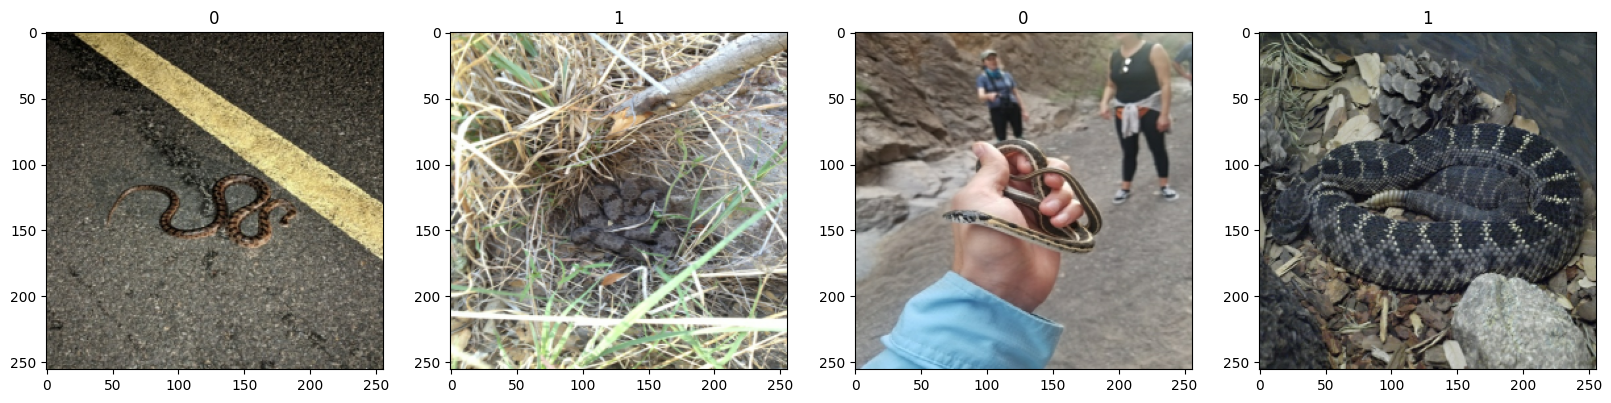

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 5. Scale Data

In [92]:
# Scaling/normalizing data by 255 
train_data = train_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))

### Testing that the scale is from 0 to 1

In [93]:
train_data.as_numpy_iterator().next()[0].min()

0.0

In [94]:
train_data.as_numpy_iterator().next()[0].max()

1.0

In [95]:
train_size = int(len(train_data)*0.9)
val_size = int(len(train_data)*0.1)

In [96]:
train = train_data.take(train_size)
val = train_data.skip(train_size).take(val_size)

# 6. Building Deep Learning Model

In [97]:
model = Sequential()

In [98]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [99]:
# Binary Cross Entropy since we will have two outputs: Poisonous, Nonpoinsonous
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [101]:
# setting location for logs 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [102]:
# fitting the model
# Might be further optimized by validation set
model_info = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
735/735 [==============================] - 327s 444ms/step - loss: 0.6601 - accuracy: 0.6362 - val_loss: 0.6588 - val_accuracy: 0.6304
Epoch 2/20
735/735 [==============================] - 356s 483ms/step - loss: 0.6536 - accuracy: 0.6376 - val_loss: 0.6579 - val_accuracy: 0.6312
Epoch 3/20
735/735 [==============================] - 352s 478ms/step - loss: 0.6484 - accuracy: 0.6404 - val_loss: 0.6680 - val_accuracy: 0.6262
Epoch 4/20
735/735 [==============================] - 354s 481ms/step - loss: 0.6354 - accuracy: 0.6505 - val_loss: 0.7559 - val_accuracy: 0.5984
Epoch 5/20
735/735 [==============================] - 367s 499ms/step - loss: 0.5987 - accuracy: 0.6751 - val_loss: 0.7850 - val_accuracy: 0.6003
Epoch 6/20
735/735 [==============================] - 360s 489ms/step - loss: 0.5446 - accuracy: 0.7070 - val_loss: 0.8738 - val_accuracy: 0.6127
Epoch 7/20
735/735 [==============================] - 365s 496ms/step - loss: 0.4978 - accuracy: 0.7378 - val_loss: 0.8580 -

### Plotting Loss and Accuracy data from training

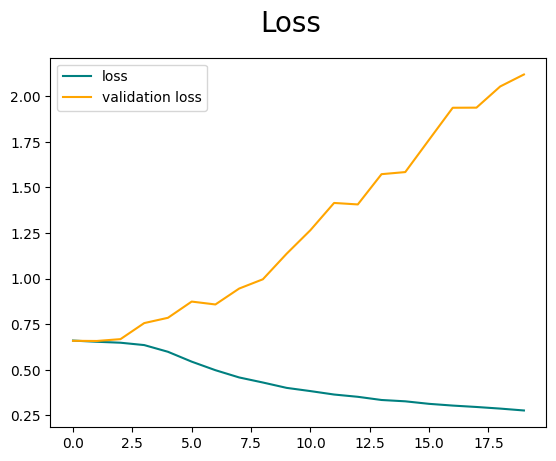

In [103]:
fig = plt.figure()
plt.plot(model_info.history['loss'], color='teal', label='loss')
plt.plot(model_info.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

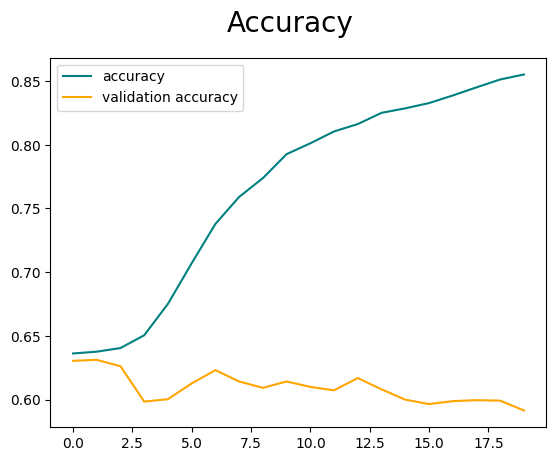

In [104]:
fig = plt.figure()
plt.plot(model_info.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_info.history['val_accuracy'], color='orange', label='validation accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [105]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [106]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

### using the model to predict if snake is 0, 1 i.e poisonous or nonpoisonous

In [109]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 43ms/step


In [108]:
# getting accuracy from test data
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.3603896200656891, Recall:0.19507908821105957, Accuracy:0.5825366377830505
